# TüEyeQ Analysis

This notebook contains experiments and plots accompanying the TüEyeQ data set. Please refer to our paper when using this script:

    [citation]

The TüEyeQ data set can be downloaded at [link].

This notebook comprises the following parts:
1. Load Packages and Data
2. General Analysis of the Raw Data (prior to pre-processing)
3. Preprocessing
4. Distance Correlations of Features
5. Logistic Regression Model

---
This code is published under the MIT license.
*Copyright (c) 2020 Johannes Haug*

# 1. Load Packages and Data

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
import shap
from lime import lime_tabular
import dcor
import pickle

In [2]:
tiq = pd.read_csv('./data/cft_full.csv')  # !!! you may need to substitute this with a different path to the data
tiq.head()

,task_id,subject,age,gender,handedness,native_german,native_german_mother,native_language_mother,native_german_father,native_language_father,...,leisure_play_games,leisure_relaxation,leisure_social_activity,leisure_humanitarian_services,leisure_nature_activities,leisure_travel_tourism,study_subject_primary,study_subject_secondary,cft_task,cft_sum_full
0,series_1,AAB14,19.0,2.0,1.0,1.0,0.0,Türkisch,0.0,Italienisch,...,0,0,1,0,1,0,"Social sciences, journalism and information",NaN,1.0,28.0
1,series_2,AAB14,19.0,2.0,1.0,1.0,0.0,Türkisch,0.0,Italienisch,...,0,0,1,0,1,0,"Social sciences, journalism and information",NaN,1.0,28.0
2,series_3,AAB14,19.0,2.0,1.0,1.0,0.0,Türkisch,0.0,Italienisch,...,0,0,1,0,1,0,"Social sciences, journalism and information",NaN,1.0,28.0
3,series_4_e,AAB14,19.0,2.0,1.0,1.0,0.0,Türkisch,0.0,Italienisch,...,0,0,1,0,1,0,"Social sciences, journalism and information",NaN,1.0,28.0
4,series_5,AAB14,19.0,2.0,1.0,1.0,0.0,Türkisch,0.0,Italienisch,...,0,0,1,0,1,0,"Social sciences, journalism and information",NaN,1.0,28.0


In [3]:
tiq.shape

(17010, 79)

# 2. General Analysis

Next, we investigate frequencies and distributions of the raw (unprocessed) data set.

## Solved Tasks

Here, we illustrate the **number of participants, who managed to solve each task correctly**. In addition, we show the incremental mean of participants and the number of unsolved tasks. Note that the tasks are shown in the order of appearance. Each block of tasks is highlighted in a different color. We also indicate all tasks with an error during the data collection process.

[]

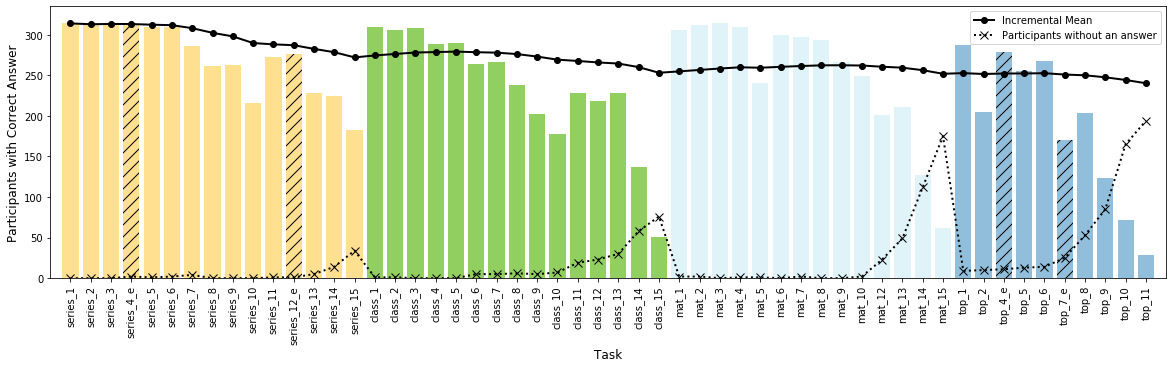

In [4]:
color_palette = ['#fee090','#91cf60','#e0f3f8','#91bfdb']
tasks = tiq.groupby('task_id', sort=False)['cft_task'].sum()  # sum of participants who solved the task
mean = pd.Series(tasks.values).expanding().mean()  # incremental mean no. of participants with correct answer

# Count number of NaNs (i.e. no. of participants that did not solve the task)
unsolved = tiq[['task_id','cft_task']].copy()
unsolved['cft_task'] = unsolved['cft_task'].isnull()
unsolved = unsolved.groupby('task_id', sort=False)['cft_task'].sum()

itr = 0  # task iterator
clr = 0  # color indicator
group_size = [15,15,14,10]  # no. tasks per group

fig = plt.figure(figsize=(20,5))

for tk in tasks.items():
    if itr == group_size[clr]:
        itr = 0  # reset iterator (next task group begins)
        clr += 1  # increment color indicator
    
    # Mark erroneous measurements with pattern
    if tk[0][-1] == 'e':
        pattern = '//'
    else:
        pattern = ''
    
    plt.bar(tk[0], tk[1], color=color_palette[clr], hatch=pattern, label='_nolegend_')
    
    itr += 1  # increment task iterator

# Line plot of incremental mean
plt.plot(unsolved.keys(), mean, color='black', lw=2, marker='.', markersize=12, label='Incremental Mean')

# Line plot of unsolved tasks
plt.plot(unsolved.keys(), unsolved.values, color='black', lw=2, ls=':', marker='x', markersize=8, label='Participants without an answer')
    
plt.ylabel('Participants with Correct Answer', size=12)
plt.xlabel('Task', size=12)
plt.xticks(rotation=90)
plt.xlim(-1, 54)
plt.ylim(0, 335)
plt.legend()

# Save histogram
plt.savefig('./figures/task_histogram.pdf', bbox_inches='tight', format='pdf')
plt.savefig('./figures/task_histogram.png', bbox_inches='tight', format='png')

plt.plot()

## Bias

We **investigate whether the data is biased against age or gender**. To this end, we plot the distribution/frequency of both variables, as well as the normalized fraction of correctly solved tasks.

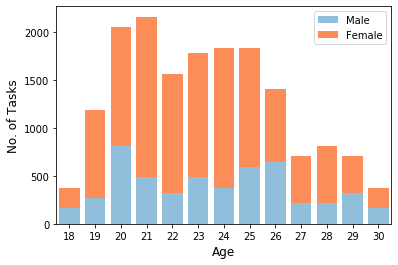

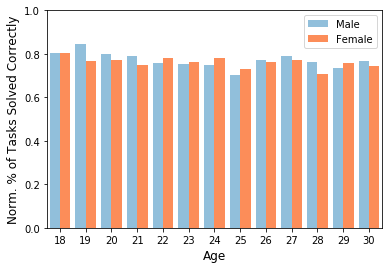

In [5]:
# Generic function to plot distribution histogram (bar chart)
def plot_bar(x, y_1, y_2, x_ticklabels, label_x, label_y, path, stacked=False):
    wd = .4
    
    if stacked:
        plt.bar(x, y_1, color='#91bfdb')
        plt.bar(x, y_2, color='#fc8d59', bottom=y_1)
    else:
        plt.bar(x - wd/2, y_1, width=wd, color='#91bfdb')
        plt.bar(x + wd/2, y_2, width=wd, color='#fc8d59')
        plt.ylim(0,1)
        
    plt.xlabel(label_x, size=12)
    plt.xticks(x, x_ticklabels)
    plt.ylabel(label_y, size=12)
    plt.xlim(min(x)-.5, max(x)+.5)
    plt.legend(['Male','Female'], loc='upper right')
    
    plt.savefig('./figures/{}.png'.format(path), bbox_inches='tight', format='png')
    plt.savefig('./figures/{}.pdf'.format(path), bbox_inches='tight', format='pdf')
    
    plt.show()
##############################################################################

# Plot histogram of age and gender
age_count_male = tiq[tiq['gender'] == 1]['age'].value_counts().sort_index()  # count male participants per age
age_count_female = tiq[tiq['gender'] == 2]['age'].value_counts().sort_index()  # count female participants per age

# Correctly solved tasks per age and gender
tasks_age_male = tiq[tiq['gender'] == 1].groupby('age', sort=False)['cft_task'].sum().sort_index()
tasks_age_female = tiq[tiq['gender'] == 2].groupby('age', sort=False)['cft_task'].sum().sort_index()


plot_bar(age_count_male.keys(), age_count_male.values, age_count_female.values, 
         age_count_male.keys().values.astype(int), 'Age', 'No. of Tasks', 'age_hist', True)
plot_bar(age_count_male.keys(), tasks_age_male.values / age_count_male.values, tasks_age_female.values / age_count_female.values,
         age_count_male.keys().values.astype(int), 'Age', 'Norm. % of Tasks Solved Correctly', 'age_tasks_norm')

## CFT Distribution

We investigate the histogram of the aggregated CFT score (cft_sum_full) and find that it is approximately normally distributed.

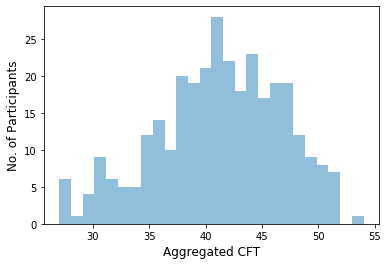

In [6]:
cft_unique = tiq[['subject', 'cft_sum_full']].drop_duplicates()  # extract unique subjects

cft_unique.hist(bins=26, color='#91bfdb')  # separate into 26 bins, since there are 26 unique aggr. CFT scores

plt.grid(False)
plt.title(None)
plt.xlabel('Aggregated CFT', size=12)
plt.ylabel('No. of Participants', size=12)

# Save histogram
plt.savefig('./figures/cft_histogram.png', bbox_inches='tight', format='png')
plt.savefig('./figures/cft_histogram.pdf', bbox_inches='tight', format='pdf')

plt.show()

# 3. Preprocessing

All subsequent analysis requires the data set to be preprocessed. For illustration, we consider a binary classification scenario of **cft_task (target)**. Specifically, we use the **true class "correct answers (label 1)"** and the **negative class "wrong answers (label 0)"**. We ignore missing answers (NaN values) in this experiment (removes 1,248 observations).

Specifically, we apply the following pre-processing steps:
1. Specify the categorical and the continuous features (according to the paper)
1. Remove all observations with missing target (i.e. NaN value in cft_task).
2. Remove subject and cft_sum_full to avoid information leakage due to high dependendy with the target.
3. Impute NaN-values in categorical features with a new category.
4. Impute NaN-values in continuous features with the median.
5. Factorize the categorical features (to encode strings as integers).
6. Normalize the continuous features to the intervall [0,1] (since we will be using l2-regularization).
7. Split data into a training and test set (20% holdout for testing)

In [7]:
# 1. Extract categorical and continuous features
ftr_cont = ['mean_grade_degree','grades_math', 'grades_german', 'grades_biology', 
            'grades_physics', 'grades_chemistry','grades_geography','grades_history','grades_art',
            'gaming_hours_weekly_min', 'gaming_hours_weekly_max', 'cft_sum_full']
ftr_cat = tiq.iloc[:,~tiq.columns.isin(ftr_cont)].columns.tolist()

# Remove the target 'cft_task' from the list of categorical features
ftr_cat.remove('cft_task')

In [8]:
# 2. Remove all observations with missing target
tiq = tiq[tiq['cft_task'].notna()]

In [9]:
# 3. Remove subject and cft_sum_full, due to possible information leakage   
# Note that we did NOT remove these variables for the computation of the distance correlation as reported in the paper
# However, it should be noted that none of these variables has a pairwise correlation above 0.5
tiq = tiq.drop(['subject','cft_sum_full'], axis=1)
ftr_cat.remove('subject')
ftr_cont.remove('cft_sum_full')

In [10]:
# 4. Impute NaN-values in categorical features with a new category
tiq[ftr_cat] = tiq[ftr_cat].fillna('new_category')

In [11]:
# 5. Impute NaN-values in continuous features with the median
medians = tiq[ftr_cont].median()
tiq[ftr_cont] = tiq[ftr_cont].fillna(medians)

In [12]:
# 6. Factorize the categorical features
tiq[ftr_cat] = tiq[ftr_cat].apply(lambda x: pd.factorize(x)[0])

In [13]:
# 7. Normalize the continuous features
tiq[ftr_cont] = MinMaxScaler().fit_transform(tiq[ftr_cont])

In [14]:
# 8. Train/Test split of the data
X_train, X_test, y_train, y_test = train_test_split(tiq.drop('cft_task', axis=1), tiq['cft_task'], test_size=.2, random_state=42)

# 4. Distance Correlations

We compute the pairwise Distance Correlation of features in a test set according to

Székely, Gábor J., Maria L. Rizzo, and Nail K. Bakirov. "Measuring and testing dependence by correlation of distances." The annals of statistics 35.6 (2007): 2769-2794.

In [ ]:
# Compute Distance Correlation (on a sample of the data)
# !!! Note that we also provide pre-computed distance correlation scores, which can be loaded in the next cell !!!
dist_crl = []
combs = set()  # save feature combinations
crl_sample = tiq.sample(frac=0.2, random_state=42)  # sample a test set (as computation of distance correlation is costly) 

for ftr1 in crl_sample:
    for ftr2 in crl_sample:
        # Check if feature combination was already evaluated (distance correlation is symmetric!)
        if '{}-{}'.format(ftr1, ftr2) not in combs and '{}-{}'.format(ftr2, ftr1) not in combs and ftr1 != ftr2:
            combs.add('{}-{}'.format(ftr1, ftr2))  # add feature pair to list of combinations
            dist_crl.append([ftr1, ftr2, dcor.distance_correlation(crl_sample[ftr1], crl_sample[ftr2])])
            print(dist_crl[-1])

dist_crl = pd.DataFrame(dist_crl, columns=['Feature 1', 'Feature 2', 'Dist. Correlation'])

In [2]:
# Save/Load the Distance correlation object
#filehandler = open('./pre-computed/distance_correlation_full.obj', 'wb')
#pickle.dump(dist_crl, filehandler)  # Save Object
filehandler = open('./pre-computed/distance_correlation.obj', 'rb')
dist_crl = pickle.load(filehandler)  # Load Object
filehandler.close()

In [3]:
# Plot most strongly correlated features
top_crl = dist_crl.reindex(dist_crl['Dist. Correlation'].sort_values(ascending=False).index).reset_index(drop=True)  # sort values
top_crl['Dist. Correlation'] = top_crl['Dist. Correlation'].round(5)  # round scores
ltx_crl = top_crl.iloc[:54,:]  # select top entries

print(ltx_crl.to_latex(index=False))  # plot in latex style

\begin{tabular}{llr}
\toprule
                   Feature 1 &                    Feature 2 &  Dist. Correlation \\
\midrule
                  gaming\_mmo &                gaming\_racing &            1.00000 \\
                     smoking &           excessive\_drinking &            1.00000 \\
     gaming\_hours\_weekly\_min &      gaming\_hours\_weekly\_max &            0.99517 \\
            gaming\_adventure &                gaming\_action &            0.93618 \\
               gaming\_action &                gaming\_casual &            0.93020 \\
               gaming\_casual &                   gaming\_rpg &            0.91362 \\
               gaming\_action &                gaming\_sports &            0.90698 \\
            gaming\_adventure &                gaming\_sports &            0.90695 \\
               gaming\_casual &                gaming\_sports &            0.90007 \\
               gaming\_action &                   gaming\_rpg &            0.89854 \\
            ga

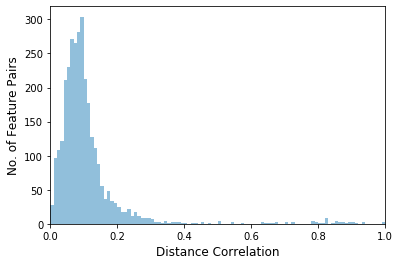

In [17]:
# Plot histogram of the distance correlation scores
def plot_hist(var, b, xmin, xlabel, ylabel, path):
    var.hist(bins=b, color='#91bfdb')

    plt.grid(False)
    plt.xlim(xmin, 1)
    plt.title(None)
    plt.xlabel(xlabel, size=12)
    plt.ylabel(ylabel, size=12)

    # Save histogram
    plt.savefig('./figures/{}_histogram.png'.format(path), bbox_inches='tight', format='png')
    plt.savefig('./figures/{}_histogram.pdf'.format(path), bbox_inches='tight', format='pdf')

    plt.show()
##############################################################################

plot_hist(dist_crl, 100, 0, 'Distance Correlation', 'No. of Feature Pairs', 'dist_corr')

In [32]:
# Plot correlation with cft_sum_full
cft_crl = top_crl[(top_crl['Feature 1'] == 'cft_sum_full') | ((top_crl['Feature 2'] == 'cft_sum_full'))].iloc[:20,:]
print(cft_crl.to_latex(index=False))  # plot in latex style

\begin{tabular}{llr}
\toprule
              Feature 1 &     Feature 2 &  Dist. Correlation \\
\midrule
            grades\_math &  cft\_sum\_full &            0.34335 \\
      mean\_grade\_degree &  cft\_sum\_full &            0.29253 \\
       grades\_chemistry &  cft\_sum\_full &            0.24498 \\
         grades\_physics &  cft\_sum\_full &            0.22522 \\
   native\_german\_father &  cft\_sum\_full &            0.21195 \\
       education\_father &  cft\_sum\_full &            0.20961 \\
               cft\_task &  cft\_sum\_full &            0.20898 \\
 native\_language\_father &  cft\_sum\_full &            0.20001 \\
         grades\_biology &  cft\_sum\_full &            0.18949 \\
 programming\_experience &  cft\_sum\_full &            0.17870 \\
      spreadsheet\_usage &  cft\_sum\_full &            0.14477 \\
   native\_german\_mother &  cft\_sum\_full &            0.13621 \\
          native\_german &  cft\_sum\_full &            0.13383 \\
      text\_editor\_us

# 5. Logistic Regression Model

For illustration, we train a simple Logistic Regression model to predict the **cft_task (target)**. We also compute the **SHAP and LIME values** to quantify every feature's contribution in the prediction.

Specifically, we perform the following training and evaluation steps:
1. Train and test the Logistic Regression (LR) model
2. Plot the weights of the LR model
3. Compute Shapley values for the LR model
4. Compute LIME values for the LR model

In [18]:
# Function to plot ROC curve
def plot_roc(y_pred, path):
    # Compute ROC-AUC Score
    auc = roc_auc_score(y_test, y_pred)

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    plt.plot(fpr, tpr, color='#4575b4', label='ROC Curve (AUC = {})'.format(round(auc, 4)), lw=2)
    plt.plot([0, 1], [0, 1], color='black', ls='--', label='_nolegend_', lw=2)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('False Positive Rate', size=12)
    plt.ylabel('True Positive Rate', size=12)
    plt.legend()

    plt.savefig('{}.pdf'.format(path), bbox_inches='tight', format='pdf')  # save as PDF
    plt.savefig('{}.png'.format(path), bbox_inches='tight', format='png')  # save as PNG    

    plt.show()

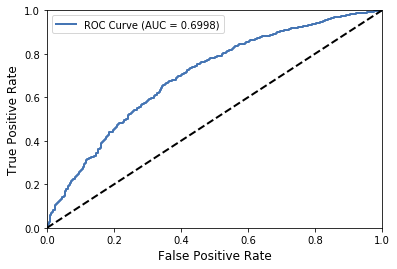

In [19]:
# 1. Train and test the LR model
model = LogisticRegression(penalty='l2', random_state=42, max_iter=1000, solver='lbfgs')
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)
plot_roc(y_pred[:,1], './figures/roc_lr')

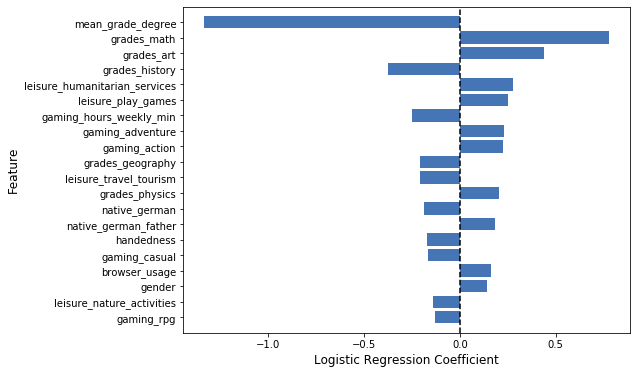

In [20]:
# 2. Plot the weights of the LR model
coef = model.coef_.flatten()
coef_idx = abs(coef).argsort()[-20:] # get indices of top coefficients
coef_sorted = coef[coef_idx]
coef_names = X_test.columns[coef_idx]  # get coefficient names

fig = plt.figure(figsize=(8,6))
plt.xlabel('Logistic Regression Coefficient', size=12)
plt.ylabel('Feature', size=12)
plt.barh(coef_names, coef_sorted, color='#4575b4')
plt.ylim(-1,20)
plt.vlines(0, -1, 21, ls='--')

plt.savefig('./figures/coef_lr.pdf', bbox_inches='tight', format='pdf')  # save as PDF
plt.savefig('./figures/coef_lr.png', bbox_inches='tight', format='png')  # save as PNG  

plt.show()

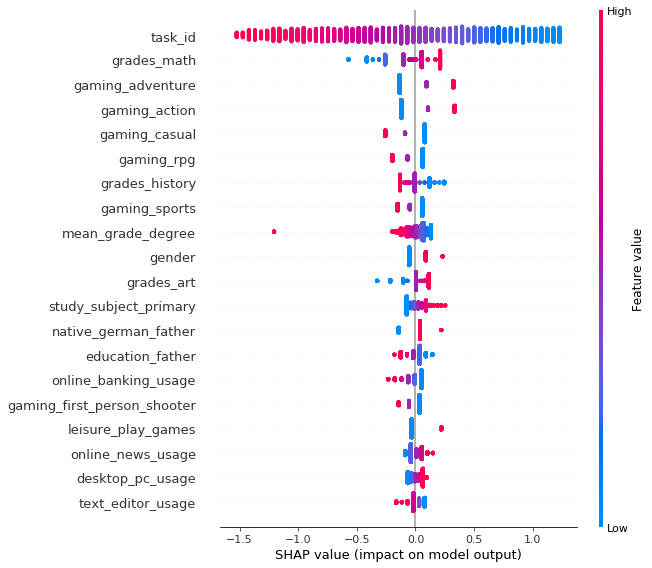

In [21]:
# 3. Compute SHAP (LinearSHAP)
reference_X = shap.sample(X_train, 100)
explainer = shap.LinearExplainer(model, reference_X)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, show=False)

plt.savefig('./figures/shap_lr.png', bbox_inches='tight', format='png')
plt.savefig('./figures/shap_lr.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [22]:
# 4. Compute LIME (TabularLIME)
lime_exp = lime_tabular.LimeTabularExplainer(
    reference_X.to_numpy(), 
    feature_names=X_test.columns.values.tolist(),
    discretize_continuous=False,
    random_state=42
)

lime_mean = np.zeros(X_test.shape[1])

for xt in X_test.to_numpy(): # Compute average LIME scores
    exp = lime_exp.explain_instance(xt, model.predict_proba, num_samples=100, num_features=X_test.shape[1], top_labels=2).local_exp
    
    for itm in exp[1]:  # collect explanations for positive class (label=1)
        lime_mean[itm[0]] += itm[1]  # sum local explanations
        
lime_mean /= X_test.shape[0]  # compute mean attribution

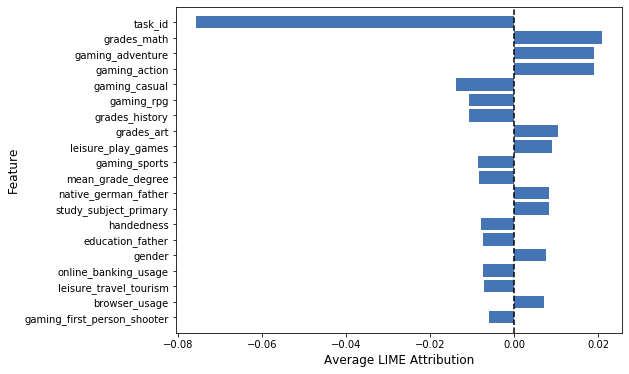

In [23]:
lime_mean_idx = abs(lime_mean).argsort()[-20:] # get indices of top coefficients
lime_mean_sorted = lime_mean[lime_mean_idx]
coef_names = X_test.columns[lime_mean_idx]  # get coefficient names

fig = plt.figure(figsize=(8,6))
plt.xlabel('Average LIME Attribution', size=12)
plt.ylabel('Feature', size=12)
plt.barh(coef_names, lime_mean_sorted, color='#4575b4')
plt.ylim(-1,20)
plt.vlines(0, -1, 21, ls='--')

plt.savefig('./figures/lime_lr.pdf', bbox_inches='tight', format='pdf')  # save as PDF
plt.savefig('./figures/lime_lr.png', bbox_inches='tight', format='png')  # save as PNG  

plt.show()